In [295]:
import ee
import geemap
import pandas as pd
import dtale
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold,train_test_split
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score,mean_absolute_percentage_error
import glob
import dask.dataframe as dd
from tpot import TPOTRegressor
import xarray as xr
from scipy import stats
from sklearn.svm import SVR
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import plot_partial_dependence
from warnings import filterwarnings
filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import plotly.express as px
import chart_studio.plotly as py
import folium
from folium.plugins import HeatMap
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
from folium.plugins import FastMarkerCluster
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import os
from sklearn.inspection import permutation_importance

In [296]:
Map_S5P = geemap.Map()
Map_S5P

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [299]:
# Create a common region of interest
roi = ee.Geometry.Polygon([[[-123.28736502403991,36.53106212747138],
        [-120.57374197716491,36.53106212747138],
        [-120.57374197716491,38.629116592353306],
        [-123.28736502403991,38.629116592353306],
        [-123.28736502403991,36.53106212747138]]])

In [286]:
# Data COllection for July
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8 = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P.addLayer(image_LANDSAT8, vis_params_L8, "Landsat-8")


In [287]:
Map_S5P_sep = geemap.Map()
Map_S5P_sep

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [288]:
# Data COllection for September
image_S5P_sep = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P_sep = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P_sep.addLayer(image_S5P_sep, vis_params_S5P_sep, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8_sep = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8_sep = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P_sep.addLayer(image_LANDSAT8_sep, vis_params_L8_sep, "Landsat-8")


In [289]:
#traing data for July
ground_truth= image_LANDSAT8.addBands(image_S5P)

# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [290]:
#traing data for September
ground_truth_sep= image_LANDSAT8_sep.addBands(image_S5P_sep)

# Make the training dataset.
points_sep = ground_truth_sep.sample(**{
    'region': ground_truth_sep.geometry(),
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P_sep.addLayer(points_sep, {}, 'training', False)

In [291]:
df = geemap.ee_to_pandas(points)
df

,B1,B10,B11,B2,B3,B4,B5,B6,B7,NO2_column_number_density,sr_aerosol
0,478.5,3056.5,3032.0,594.0,940.0,843.0,3500.0,2249.5,1434.0,0.000093,160
1,260.5,3060.0,3035.5,333.0,539.5,523.0,1883.5,1556.5,927.0,0.000088,177
2,453.0,3065.5,3036.0,651.5,1093.5,1369.0,2180.5,2280.5,1681.0,0.000101,145
3,655.5,3130.0,3095.5,877.5,1334.0,1932.5,3458.0,3783.0,2388.5,0.000092,98
4,3086.0,2859.5,2862.5,3078.0,2960.0,2921.5,2900.5,2503.5,1881.5,0.000063,38
...,...,...,...,...,...,...,...,...,...,...,...
4995,301.5,3069.5,3050.0,458.0,811.5,1154.5,3075.5,2875.0,1591.0,0.000094,96
4996,626.0,3076.0,3042.5,870.5,1289.0,1612.0,2946.5,3258.0,2413.0,0.000102,192
4997,4410.5,2841.5,2842.5,4431.0,4454.0,4542.0,4672.5,3779.0,2904.5,0.000072,8
4998,3839.0,2840.5,2837.5,3852.0,3833.0,3888.0,4006.5,3633.0,3190.5,0.000072,8


In [293]:
#df.to_csv ('LandSat8_S5_San_Francisco_July_5000_Points.csv', index = False, header=True)

In [292]:
df_sep = geemap.ee_to_pandas(points_sep)
df_sep

,B1,B10,B11,B2,B3,B4,B5,B6,B7,NO2_column_number_density,sr_aerosol
0,669.5,3083.0,3057.5,774.0,977.0,1133.0,1591.5,2317.5,2026.5,0.000084,96
1,290.0,2949.0,2923.0,341.0,569.0,580.0,2166.0,1820.0,1065.0,0.000069,130
2,469.0,3045.0,3024.0,640.0,1101.0,1318.0,1930.0,2193.0,1740.0,0.000086,96
3,562.0,3090.0,3068.0,808.0,1368.0,2027.0,3632.0,3982.0,2440.0,0.000075,100
4,4744.0,2828.5,2829.0,4773.0,4711.0,4829.0,4997.5,4644.0,3972.5,0.000066,8
...,...,...,...,...,...,...,...,...,...,...,...
4995,288.0,3037.0,3022.0,415.5,734.0,1060.5,2735.5,2634.0,1387.5,0.000087,96
4996,1427.0,2843.0,2868.0,1447.0,1679.0,1906.0,3559.0,2839.0,2160.0,0.000095,8
4997,4391.0,2854.0,2858.0,4424.5,4468.5,4549.0,4654.5,3483.0,2578.0,0.000070,8
4998,5963.0,2845.0,2847.0,6073.5,6166.5,6314.5,6486.0,5134.5,4104.5,0.000069,8


In [294]:
#df_sep.to_csv ('LandSat8_S5_San_Francisco_Sep_5000_Points.csv', index = False, header=True)

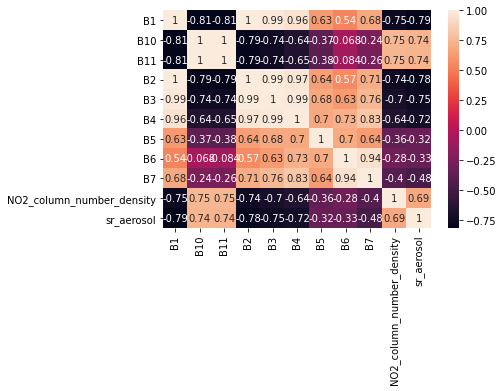

In [270]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

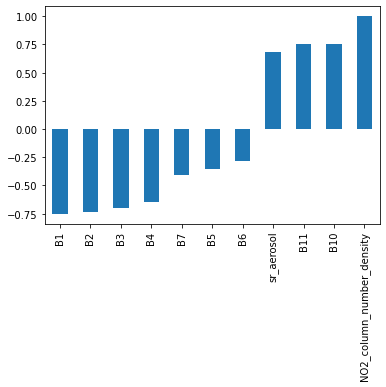

In [271]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

It looks like B1, B2, B3, B4, B10, B11, and sr-aerosol strongly correlate with the NO2 values. It will be good to see how do they perform in a fitted model.

## ! Notes to Toyon !

- Can you run a multivariate regression model for this data, and document p-values?
- Can you run a machine learning model (e.g random forest/GBM) to fit this data? Document the feature importance. You can divide the data into train and test to see how well it performs within the month. 
- Can you test it on a different month (September 2018)? To see the divergence.
- Can you try generating the similar dataset for June 2018 using Sentinel-2 and Sentinel-5P data?
- Side note: we may have to generate additional spatial and temporal values (month, day of week, etc.) in the future to develop more precise models.

In [272]:
dtale.show(df)

In [273]:
df.isnull().sum()

B1                           0
B10                          0
B11                          0
B2                           0
B3                           0
B4                           0
B5                           0
B6                           0
B7                           0
NO2_column_number_density    0
sr_aerosol                   0
dtype: int64

In [274]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [275]:
X_sep=df_sep.drop('NO2_column_number_density',axis=1).values
y_sep=df_sep['NO2_column_number_density'].values

X_train_sep, X_test_sep, y_train_sep, y_test_sep = train_test_split(X_sep, y_sep, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train_sep=scaler.fit_transform(X_train_sep)
X_test_sep=scaler.transform(X_test_sep)

In [276]:
# cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
# model = TPOTRegressor(generations=4, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, random_state=42, n_jobs=-1)
# model.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/250 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -4.529442946966777e-06

Generation 2 - Current best internal CV score: -4.490338574037101e-06

Generation 3 - Current best internal CV score: -4.490338574037101e-06

Generation 4 - Current best internal CV score: -4.490338574037101e-06

Best pipeline: RandomForestRegressor(PCA(RobustScaler(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False)), iterated_power=9, svd_solver=randomized), bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=7, min_samples_split=20, n_estimators=100)


TPOTRegressor(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=42),
              generations=4, n_jobs=-1, population_size=50, random_state=42,
              scoring='neg_mean_absolute_error', verbosity=2)

Warning: xgboost.XGBRegressor is not available and will not be used by TPOT.

Generation 1 - Current best internal CV score: -4.529442946966777e-06

Generation 2 - Current best internal CV score: -4.490338574037101e-06

Generation 3 - Current best internal CV score: -4.490338574037101e-06

Generation 4 - Current best internal CV score: -4.490338574037101e-06

## Best pipeline: RandomForestRegressor(PCA(RobustScaler(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False)), iterated_power=9, svd_solver=randomized), bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=7, min_samples_split=20, n_estimators=100)
## TPOTRegressor(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=42),
              generations=4, n_jobs=-1, population_size=50, random_state=42,
              scoring='neg_mean_absolute_error', verbosity=2)

In [277]:

#model.export('NO2_Prediction_KR_Toyon_July_September_LandSat8_S5_San_Francisco_tpot_best_model.py')

In [278]:
model = RandomForestRegressor(bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=7, min_samples_split=20, n_estimators=100)
model.fit(X_train, y_train)
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.908
Test Accuracy : 0.813


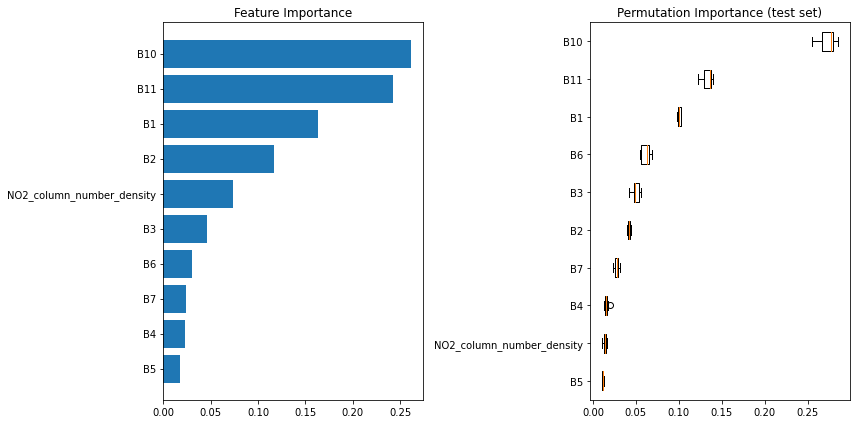

In [279]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.title('Feature Importance')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(df.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Mean Squared Error = 4.34063839411129e-11
Mean absolute percentage error = 0.05364495390357321


Text(0, 0.5, 'NO2_column_number_density')

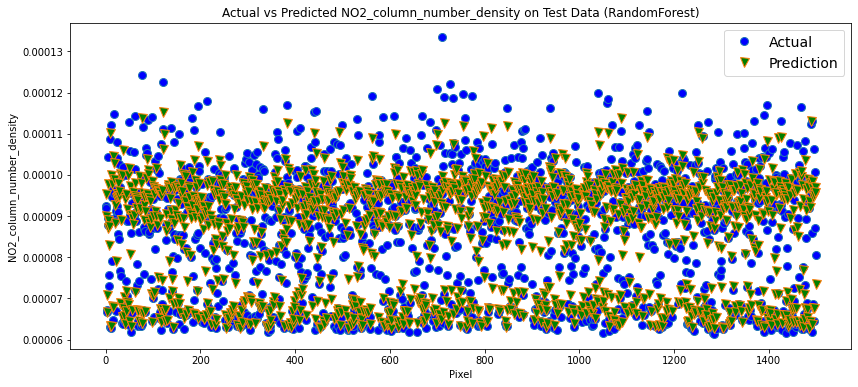

In [280]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Mean Squared Error = 2.6159247156642026e-10
Mean absolute percentage error = 0.19890014648428234


Text(0, 0.5, 'NO2_column_number_density')

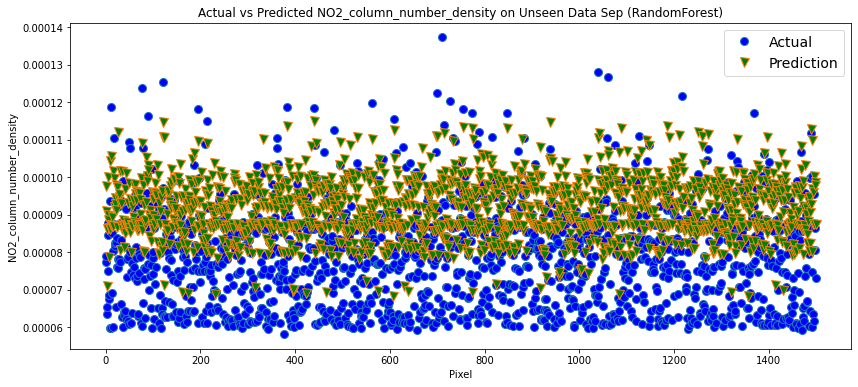

In [281]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Text(0, 0.5, 'NO2_column_number_density')

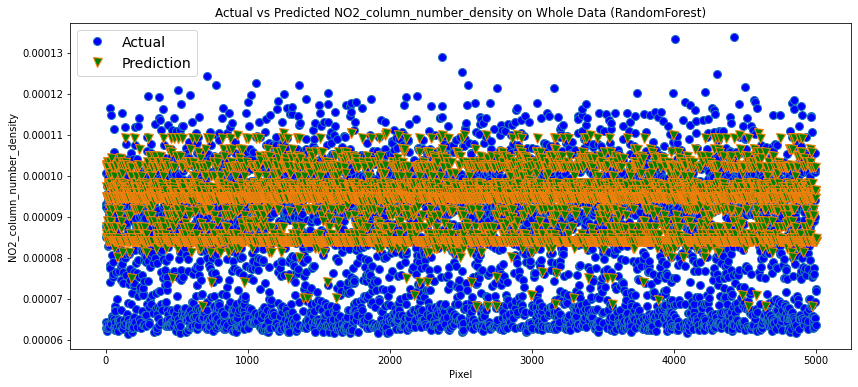

In [282]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

## Additional Methods follows below

In [229]:
model_params = {
    'svm': {
        'model': SVR(gamma='auto'),
        'params' : {
            'C': [10,20,50],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [5,10,15]
        }
    },
}

In [230]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score

,model,best_score,best_params
0,svm,-0.501760,"{'C': 10, 'kernel': 'rbf'}"
1,random_forest,0.801477,{'n_estimators': 15}


In [231]:
#Rainforest Regression
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=15)
model.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=15)

In [232]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.774
Test Accuracy : 0.764


Mean Squared Error = 5.468839960336403e-11
Mean absolute percentage error = 0.0683534856829272


Text(0, 0.5, 'NO2_column_number_density')

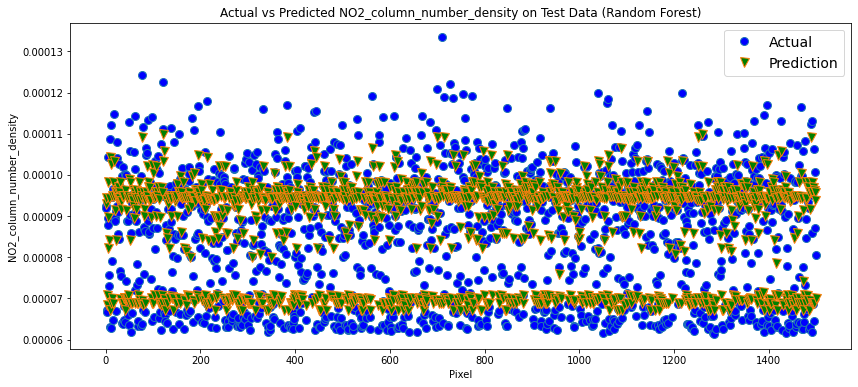

In [233]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Mean Squared Error = 2.549559222665694e-10
Mean absolute percentage error = 0.1977717838705962


Text(0, 0.5, 'NO2_column_number_density')

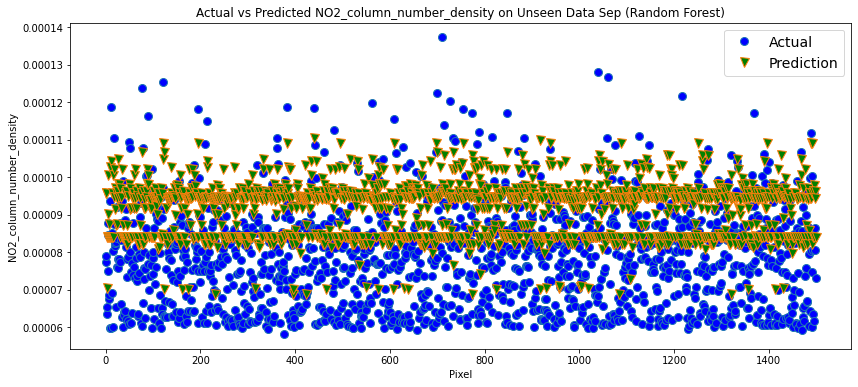

In [234]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [235]:
NO2_column_number_density=df['NO2_column_number_density']

In [236]:
X_all=scaler.transform(X)
all_prediction=model.predict(X_all)

Text(0, 0.5, 'NO2_column_number_density')

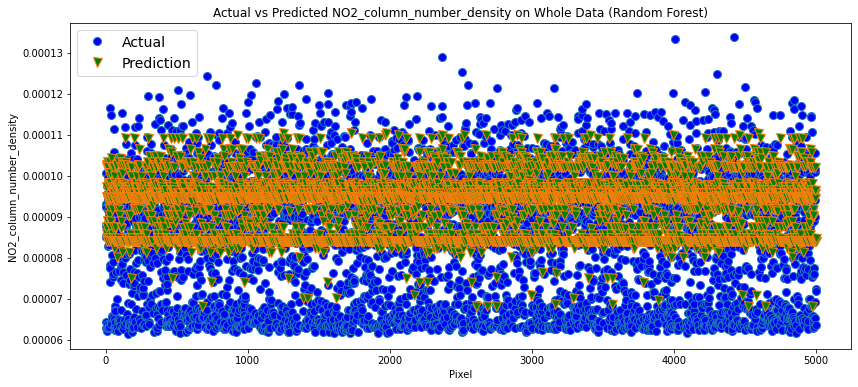

In [237]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [238]:
#X.rename(index={0: "B1", 1: "B10", 2: "B11", 3: "B2",4: "B3", 5: "B4", 6: "B5", 7: "B6", 8: "B7"})

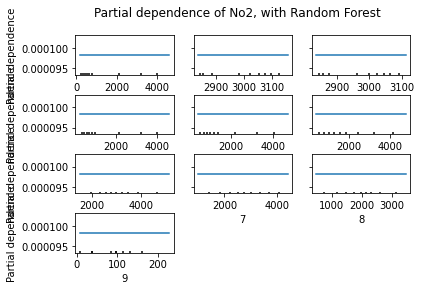

In [239]:
display = plot_partial_dependence(
       model, X, features=[0,1,2,3,4,5,6,7,8,9])

display.figure_.suptitle('Partial dependence of No2, with Random Forest')
display.figure_.subplots_adjust(hspace=0.5)

In [240]:
logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          1.772e+04
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:31:33   Log-Likelihood:                          34627.
No. Observations:                3500   AIC:                                 -6.923e+04
Df Residuals:                    3490   BIC:                                 -6.917e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Start Mutlti-OutPut Regression Here! 
## With Target Output  
## y=  ['NO2_column_number_density','tropospheric_NO2_column_number_density']

In [300]:
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density','tropospheric_NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")



In [301]:
image_LANDSAT8_sep = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8_sep = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P_sep.addLayer(image_LANDSAT8_sep, vis_params_L8_sep, "Landsat-8")

In [302]:
ground_truth= image_LANDSAT8.addBands(image_S5P)

In [303]:
# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [304]:
df = geemap.ee_to_pandas(points)
df

,B1,B10,B11,B2,B3,B4,B5,B6,B7,NO2_column_number_density,sr_aerosol,tropospheric_NO2_column_number_density
0,478.5,3056.5,3032.0,594.0,940.0,843.0,3500.0,2249.5,1434.0,0.000093,160,0.000036
1,260.5,3060.0,3035.5,333.0,539.5,523.0,1883.5,1556.5,927.0,0.000088,177,0.000029
2,453.0,3065.5,3036.0,651.5,1093.5,1369.0,2180.5,2280.5,1681.0,0.000101,145,0.000042
3,655.5,3130.0,3095.5,877.5,1334.0,1932.5,3458.0,3783.0,2388.5,0.000092,98,0.000032
4,3086.0,2859.5,2862.5,3078.0,2960.0,2921.5,2900.5,2503.5,1881.5,0.000063,38,0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,301.5,3069.5,3050.0,458.0,811.5,1154.5,3075.5,2875.0,1591.0,0.000094,96,0.000037
4996,626.0,3076.0,3042.5,870.5,1289.0,1612.0,2946.5,3258.0,2413.0,0.000102,192,0.000044
4997,4410.5,2841.5,2842.5,4431.0,4454.0,4542.0,4672.5,3779.0,2904.5,0.000072,8,0.000023
4998,3839.0,2840.5,2837.5,3852.0,3833.0,3888.0,4006.5,3633.0,3190.5,0.000072,8,0.000020


In [305]:
df.to_csv ('LandSat8_S5_San_Francisco_July_Multi_5000_Points.csv', index = False, header=True)

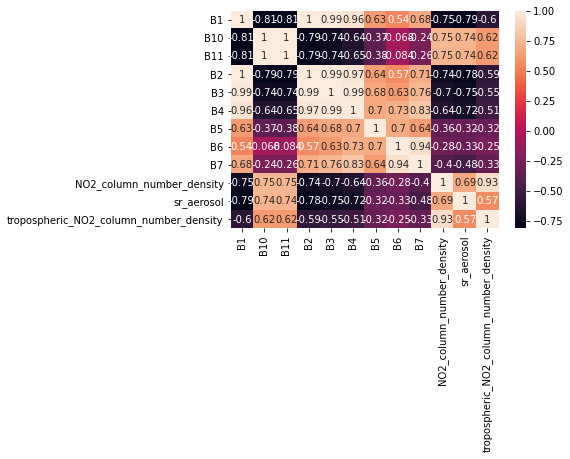

In [247]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

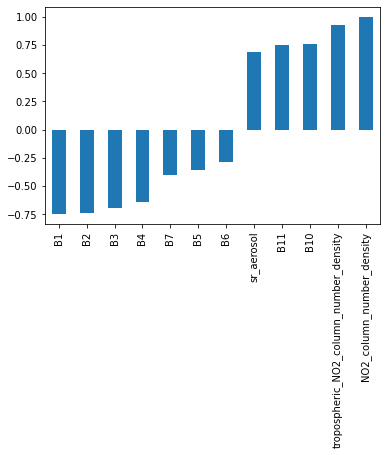

In [248]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

In [249]:
X=df.drop(['NO2_column_number_density','tropospheric_NO2_column_number_density'],axis=1).values
y=df[['NO2_column_number_density','tropospheric_NO2_column_number_density']].values


In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Linear Regression for Multioutput Regression

8.793669419223117e-05
Mean Squared Error = 6.323691553905257e-11
Mean absolute percentage error = 0.07112537833987996
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          1.772e+04
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:32:13   Log-Likelihood:                          34627.
No. Observations:                3500   AIC:                                 -6.923e+04
Df Residuals:                    3490   BIC:                                 -6.917e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
  

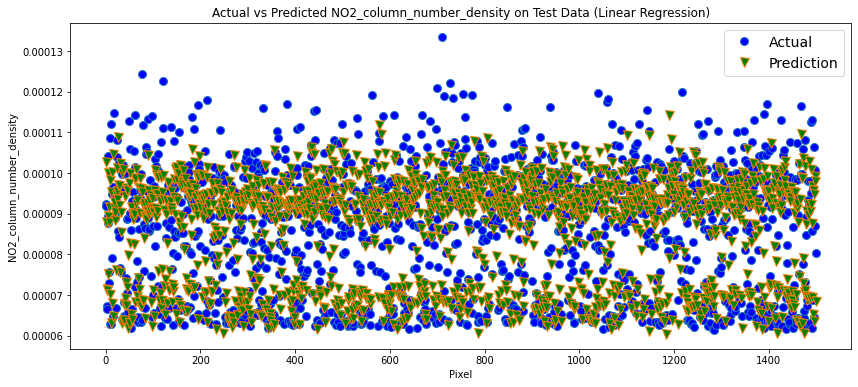

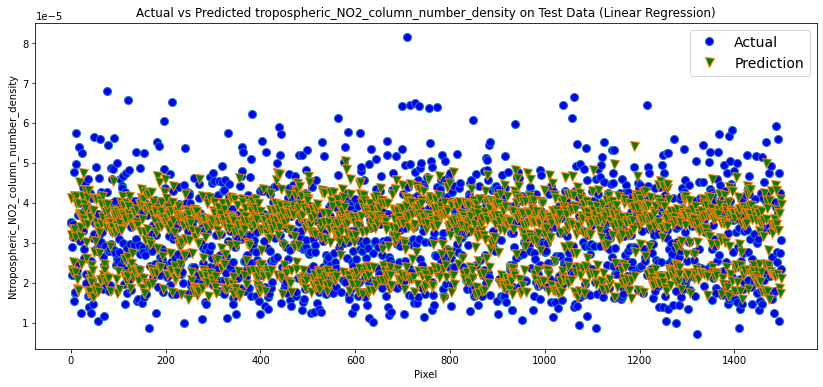

In [251]:
# defining LinearRegression model
model = LinearRegression()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

##
MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,1],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,1],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted tropospheric_NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('Ntropospheric_NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [252]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.617
Test Accuracy : 0.623


# k-Nearest Neighbors for Multioutput Regression

9.52969838296504e-05
Mean Squared Error = 4.91271873108814e-11
Mean absolute percentage error = 0.0563972106748753
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          1.772e+04
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:32:15   Log-Likelihood:                          34627.
No. Observations:                3500   AIC:                                 -6.923e+04
Df Residuals:                    3490   BIC:                                 -6.917e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
     

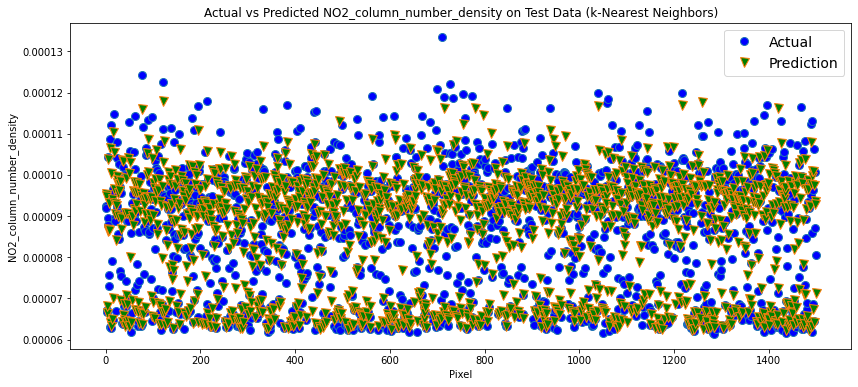

In [253]:
# define model
model = KNeighborsRegressor()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (k-Nearest Neighbors)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [254]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.786
Test Accuracy : 0.680


# Decision Tree for Multioutput Regression

8.828501538010272e-05
Mean Squared Error = 5.6022342174246196e-11
Mean absolute percentage error = 0.06498630153290957
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          1.772e+04
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:32:16   Log-Likelihood:                          34627.
No. Observations:                3500   AIC:                                 -6.923e+04
Df Residuals:                    3490   BIC:                                 -6.917e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
 

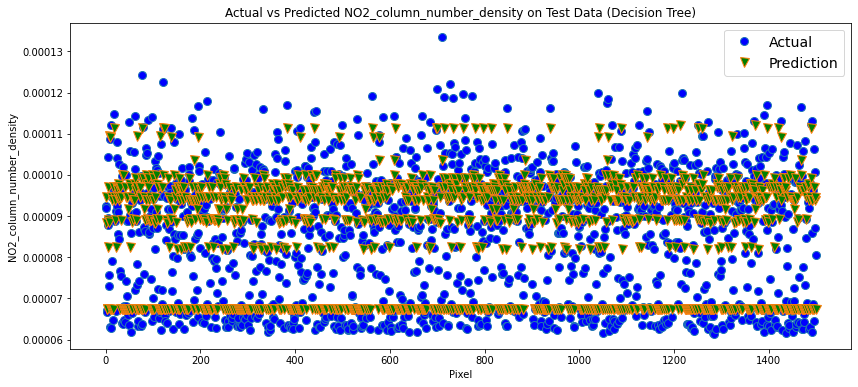

In [255]:
# define model
model = DecisionTreeRegressor(max_depth=8,
                           min_samples_split=5,
                           max_leaf_nodes=20)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [256]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.683
Test Accuracy : 0.651


In [257]:
#y_train.shape

In [258]:
# param_grid = {"criterion": ["mse", "mae"],
#               "min_samples_split": [10, 20, 40],
#               "max_depth": [2, 6, 8],
#               "min_samples_leaf": [20, 40, 100],
#               "max_leaf_nodes": [5, 20, 100],
#               }

# ## Comment in order to publish in kaggle.

# grid_cv_dtm = GridSearchCV(model, param_grid, cv=5)

# grid_cv_dtm.fit(X,y)

# print("R-Squared::{}".format(grid_cv_dtm.best_score_))
# print("Best Hyperparameters::\n{}".format(grid_cv_dtm.best_params_))

Mean Squared Error = 5.620408069110051e-12
Mean absolute percentage error = 0.01974329052796157
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          4.074e+04
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:32:20   Log-Likelihood:                          36231.
No. Observations:                3500   AIC:                                 -7.244e+04
Df Residuals:                    3489   BIC:                                 -7.237e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef   

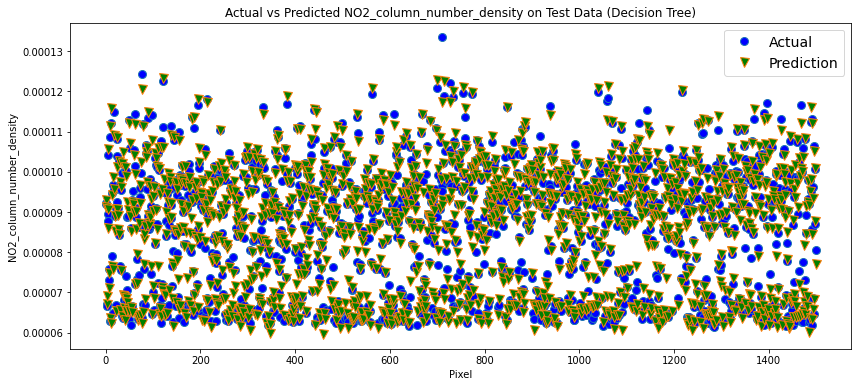

In [259]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

model = GradientBoostingRegressor(alpha=0.85, learning_rate=0.5, loss='lad', max_depth=15, max_features=0.9500000000000001,
                                min_samples_leaf=12, min_samples_split=7, n_estimators=100, subsample=0.6500000000000001)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction[0,0])

MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))